**Сборный проект. ДТП риски**
_____
**Описание исследования.**

Для каршеринговой копмании нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения.
Под риском понимается вероятность ДТП с любым повреждением транспортного средства.
Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска.
Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.
Идея создания такой системы находится в стадии предварительного обсуждения и проработки.
Чёткого алгоритма работы и подобных решений на рынке ещё не существует.
    
_____
**Цель исследования.**

Создать систему оценки рисков и понять возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.

**Задачи исследования.**

- Загрузить таблицы sql

- Провести первичное исследование таблиц

- Внести корректировки по результатам исследовательского анализа

- Провести статистический анализ факторов ДТП

- Создать модель для оценки водительского риска

- Найти лучшую модель перебором гиперпараметров

- Проанализировать модель в работе ииследуя важность факторов влияющих на вероятность ДТП

- Сделать общий вывод по моделе

_____
**Исходные данные.**

База данных `data-science-vehicle-db` содержит таблицы:

- `collisions` — общая информация о ДТП

- `parties` — информация об участниках ДТП

- `vehicles` — информация о пострадавших машинах

_____
**Содержание проекта.**

***Шаг 1. Загрузка данных:***
* [Загрузка библиотек.](#1-bullet)
* [Подключение к БД.](#2-bullet)

***Шаг 2. Первичное исследование таблиц***
* [Изучение БД](#3-bullet)

***Шаг 3. Статистический анализ факторов ДТП***
* [Оценка ежемесячных аварий](#4-bullet)
* [Аналитические задачи](#5-bullet)
* [Задача 1](#6-bullet)
* [Задача 3](#7-bullet)

***Шаг 4. Создание модели для оценки водительского риска***
* [Подготовка набора данных](#8-bullet)
* [Исследовательский анализ и изменение данных](#9-bullet)
* [Подготовка выборок для обучения](#10-bullet)

***Шаг 5. Поиск лучшей модели***
* [Функция для обучения](#11-bullet)
* [Гиперпараметры моделей](#12-bullet)
* [Результат обучения](#13-bullet)

***Шаг 6. Проверка лучшей модели***
* [Оценка качества определения классов](#14-bullet)
* [Матрица ошибок](#15-bullet)
* [Анализ важности признаков](#16-bullet)

***Общий вывод***


## Шаг 1. Загрузка данных:

### Загрузка библиотек
<a id='1-bullet'></a>

In [ ]:
#Установка нужных бибилотек
import sys
!"{sys.executable}" -m pip install phik -q
!"{sys.executable}" -m pip install shap -q
!"{sys.executable}" -m pip install catboost -q
!"{sys.executable}" -m pip install category-encoders -q
!"{sys.executable}" -m pip install sqlalchemy -q

#Импорт стандартных библиотек Python
import os
import re
import math
import time
import warnings
from datetime import datetime
from itertools import product
from warnings import simplefilter

#Обработка данных
import numpy as np
import pandas as pd
from scipy import stats

#Машинное обучение и обработка данных
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, r2_score, roc_auc_score, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, OrdinalEncoder, RobustScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils.validation import check_random_state

#Специализированные библиотеки для машинного обучения
from catboost import CatBoostClassifier, CatBoostRegressor
#from imblearn.over_sampling import SMOTE
from lightgbm import LGBMRegressor

#Визуализация данных
import matplotlib.pyplot as plt
import seaborn as sns

#Объяснимость моделей
import shap
from phik import phik_matrix
from phik.report import plot_correlation_matrix

#БД
from sqlalchemy import create_engine, text

simplefilter(action='ignore', category=FutureWarning)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


### Подключение к БД
<a id='2-bullet'></a>

In [ ]:
#Данные для подключения к БД
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
}

#Строка для подключения
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

#Функция для подключения
engine = create_engine(connection_string)

## Шаг 2. Первичное исследование таблиц

### Изучение БД
<a id='3-bullet'></a>

In [ ]:
#Функция для оценки БД
def analyze_database():

    engine = create_engine(connection_string)

    tables_query = text('''
    SELECT table_name,
           COUNT(*)
    FROM information_schema.tables
    WHERE table_schema = 'public'
    GROUP BY table_name
    ''')

    with engine.connect() as conn:
         tables_result = conn.execute(tables_query).fetchall()

    tables = [row[0] for row in tables_result]

    print("Список всех таблиц:")
    for table in tables:
        print(table)

    print("\nАнализ таблиц")

    def get_table_info(table_name):
        query = text(f'''
        SELECT column_name, data_type
        FROM information_schema.columns
        WHERE table_name = '{table_name}'
        AND table_schema = 'public'
        ORDER BY ordinal_position
        ''')

        with engine.connect() as conn:
            columns_result = conn.execute(query).fetchall()

        return columns_result

    def get_rows(table_name):
        query = text(f'''
        SELECT *
        FROM {table_name}
        LIMIT 5
        ''')

        with engine.connect() as conn:
            result = conn.execute(query).fetchall()

        return result

    def count_total_rows(table_name):
        query = text(f'SELECT COUNT(*) FROM {table_name}')
        with engine.connect() as conn:
            result = conn.execute(query).fetchone()[0]
        return result

    for table_name in tables:
        columns_info = get_table_info(table_name)
        rows = get_rows(table_name)
        total_count = count_total_rows(table_name)

        print(f"\nТаблица: {table_name}")
        print("\nСтруктура таблицы:")
        for column in columns_info:
            print(f"- {column[0]} ({column[1]})")

        print("\nПервые 5 строк:")
        if rows:
            df = pd.DataFrame(rows, columns=[col[0] for col in columns_info])
            print(df.to_string(index=False))
        else:
            print("Таблица пуста.")

        print(f"\nОбщее кол-во строк: {total_count}")

analyze_database()


Список всех таблиц:
collisions
vehicles
parties
case_ids

Анализ таблиц

Таблица: collisions

Структура таблицы:
- case_id (text)
- county_city_location (text)
- county_location (text)
- distance (real)
- direction (text)
- intersection (integer)
- weather_1 (text)
- location_type (text)
- collision_damage (text)
- party_count (integer)
- primary_collision_factor (text)
- pcf_violation_category (text)
- type_of_collision (text)
- motor_vehicle_involved_with (text)
- road_surface (text)
- road_condition_1 (text)
- lighting (text)
- control_device (text)
- collision_date (date)
- collision_time (time without time zone)

Первые 5 строк:
case_id county_city_location county_location  distance direction  intersection weather_1 location_type collision_damage  party_count primary_collision_factor  pcf_violation_category type_of_collision motor_vehicle_involved_with road_surface road_condition_1                lighting control_device collision_date collision_time
4083072                 1942   

<b>Выводы:</b>

- Общим ключом к таблицам в базе данных является `case_id`

- Количество и состояние таблиц соответствуют условиям задачи

## Шаг 3. Статистический анализ факторов ДТП

### Оценка ежемесячных аварий
<a id='4-bullet'></a>

In [ ]:
date_accident = '''
SELECT
    EXTRACT(YEAR FROM collision_date) AS year,
    EXTRACT(MONTH FROM collision_date) AS month,
    COUNT(*) AS collision_count
FROM
    collisions
GROUP BY
    year, month
ORDER BY
    year, month;
'''

df_date_ac = pd.read_sql(date_accident, engine)

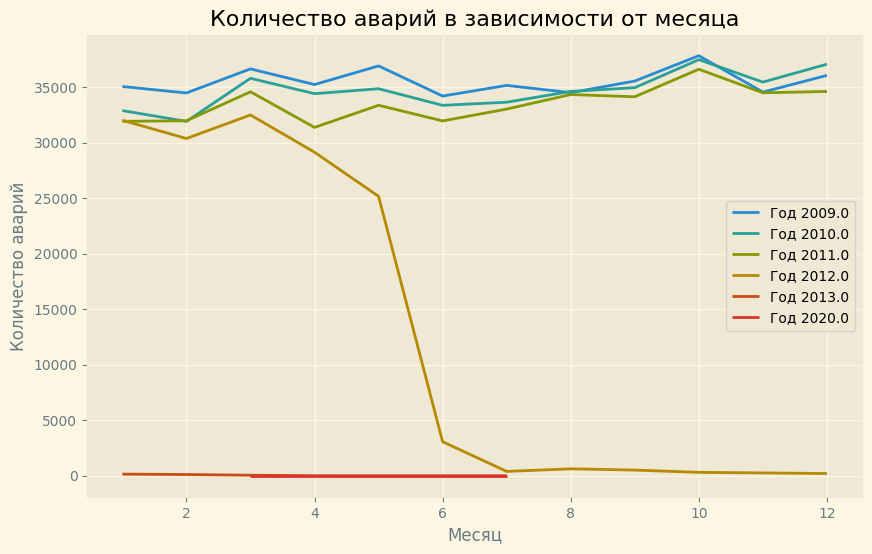

Количество ежегодных аварий: year
2009.0    426228
2010.0    416490
2011.0    402428
2012.0    154547
2013.0       305
2020.0         2
Name: collision_count, dtype: int64


In [ ]:
plt.style.use('Solarize_Light2')

plt.figure(figsize=(10, 6))
for year in df_date_ac['year'].unique():
    year_data = df_date_ac[df_date_ac['year'] == year]
    plt.plot(year_data['month'], year_data['collision_count'], label=f'Год {year}')

plt.title('Количество аварий в зависимости от месяца')
plt.xlabel('Месяц')
plt.ylabel('Количество аварий')
plt.legend()
plt.grid(True)
plt.show()

ac_counts = df_date_ac.groupby('year')['collision_count'].sum()
print("Количество ежегодных аварий:", ac_counts)

<b>Выводы:</b>

- Отсутствуют данные аварий с 2014 по 2020 годы

- В 2020 году зафиксированны всего 2 аварии, явно таблица с +- середины 2013 не ведётся

- В 2012 году наблюдается резкая просадка в кол-ве аварий во втором полугодии

- В первые 3 года наблюдений заметна тенденция к снижению ежегодного числа аварий с небольшим увеличением кол-ва поздней осенью

### Аналитические задачи
<a id='5-bullet'></a>

**Список задач для потенциального рассмотрения и решения**:

1. Анализ влияния времени суток и освещения на степень повреждения транспортного средства

2. Зависимость серьезности повреждений от дорожного состояния и типа кузова автомобиля

3. Самые частые причины и типы участников ДТП

4. Влияние состояния и трезвости водителя на серьезность повреждений

5. Связь локации и отдалённости от главной дороги с категорией нарушения

6. Оценить взаимосвязь типа КПП и возраста авто с сезоном, состоянием дороги и погодными условиями аварии

### Задача 1
<a id='6-bullet'></a>

In [ ]:
df_light = pd.read_sql_query('''

WITH collision_time_extract AS (
    SELECT
        collision_date,
        EXTRACT(HOUR FROM collision_time) AS collision_hour,
        lighting,
        collision_damage
    FROM
        collisions
)
SELECT
    CASE
        WHEN collision_hour BETWEEN 0 AND 5 THEN 'Ночь'
        WHEN collision_hour BETWEEN 6 AND 11 THEN 'Утро'
        WHEN collision_hour BETWEEN 12 AND 17 THEN 'День'
        ELSE 'Вечер'
    END AS time_of_day,
    lighting,
    collision_damage,
    COUNT(*) AS collision_count
FROM
    collision_time_extract
GROUP BY
    time_of_day,
    lighting,
    collision_damage;

''', engine)

print(df_light.head(2))

  time_of_day                    lighting collision_damage  collision_count
0       Вечер  dark with no street lights            fatal             1240
1       Вечер  dark with no street lights    middle damage             7366


<Figure size 1400x800 with 0 Axes>

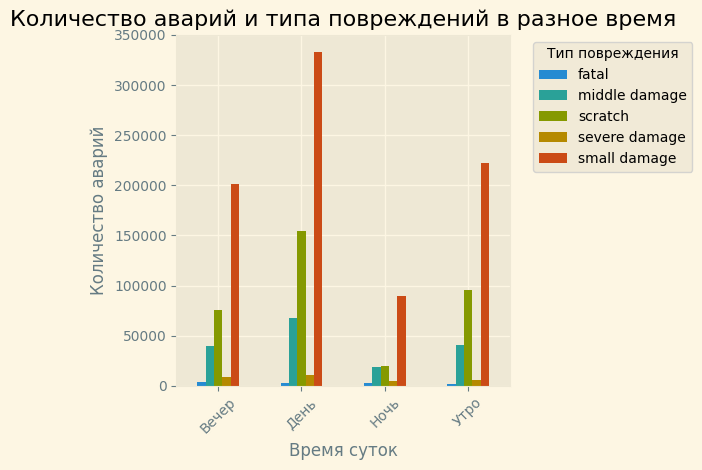

In [ ]:

time_damage = df_light.groupby(['time_of_day', 'collision_damage']).agg({'collision_count':
                                                                   'sum'}).reset_index()

#Создание столбчатой диаграммф
plt.figure(figsize=(14, 8))
ax = time_damage.pivot(index='time_of_day', columns='collision_damage',
                       values='collision_count').plot(kind='bar')

ax.set_xlabel('Время суток')
ax.set_ylabel('Количество аварий')
ax.set_title('Количество аварий и типа повреждений в разное время')

plt.legend(title='Тип повреждения', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



<Figure size 1000x500 with 0 Axes>

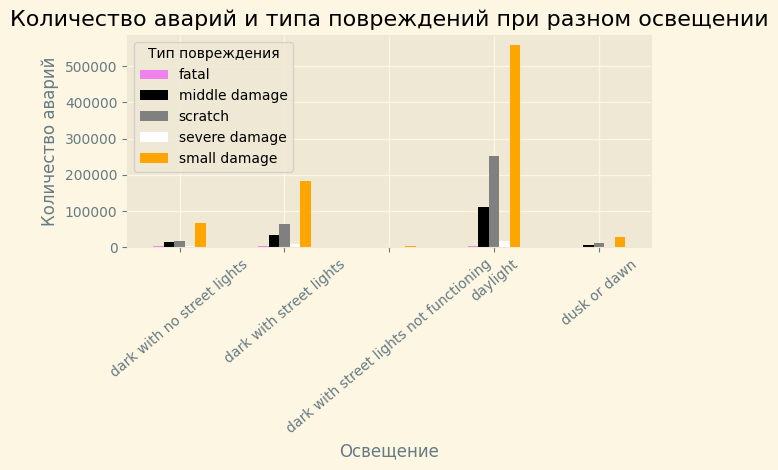

In [ ]:
light_damage = df_light.groupby(['lighting', 'collision_damage']).agg({'collision_count':
                                                                 'sum'}).reset_index()

plt.figure(figsize=(10, 5))
ax = light_damage.pivot(index='lighting', columns='collision_damage',
                       values='collision_count').plot(kind='bar',
                                                      color=['violet', 'black', 'grey',
                                                             'white', 'orange'])

ax.set_xlabel('Освещение')
ax.set_ylabel('Количество аварий')
ax.set_title('Количество аварий и типа повреждений при разном освещении')

plt.legend(title='Тип повреждения')
plt.xticks(rotation=40)

plt.tight_layout()
plt.show()

<b>Выводы:</b>

- Аварии в основном происходят в дневное время при хорошем освещении

- Перобладают незначительные повреждения и "царапины"  

### Задача 3
<a id='7-bullet'></a>

In [ ]:
df_cause = pd.read_sql_query('''

SELECT
    p.PARTY_TYPE AS "Тип участника",
    COUNT(DISTINCT p.CASE_ID) AS "Кол-во участников",
    c.primary_collision_factor AS "Основной фактор аварии",
    COUNT(DISTINCT c.CASE_ID) AS "Кол-во аварий по фактору"
FROM
    parties p
JOIN
    collisions c ON p.CASE_ID = c.CASE_ID
GROUP BY
    p.PARTY_TYPE, c.primary_collision_factor
ORDER BY
    COUNT(DISTINCT c.CASE_ID) DESC;

''', engine)

print(df_cause.head(2))

  Тип участника  Кол-во участников  Основной фактор аварии  \
0           car            1309468  vehicle code violation   
1   road bumper             124561  vehicle code violation   

   Кол-во аварий по фактору  
0                   1309468  
1                    124561  


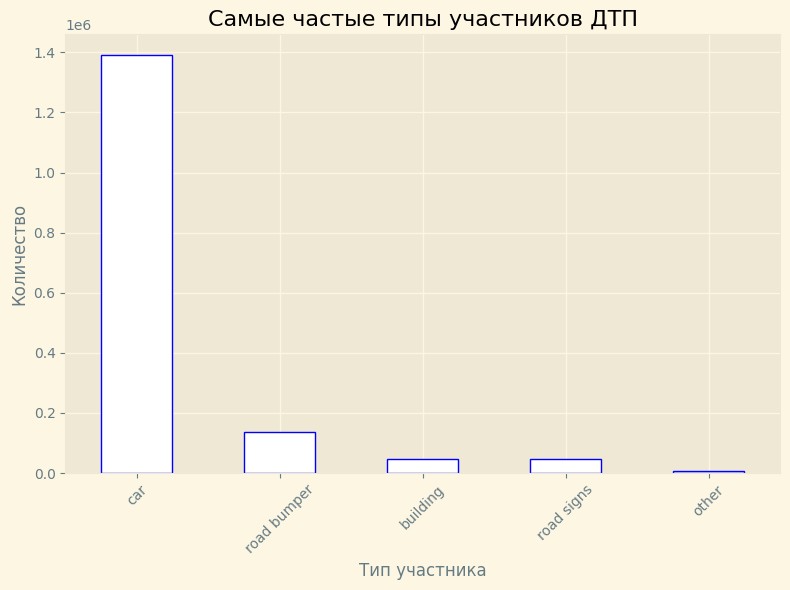

In [ ]:
plt.figure(figsize=(8, 6))

top_participants = df_cause.groupby('Тип участника')['Кол-во участников'].sum().nlargest()

top_participants.plot(kind='bar', color='white', edgecolor='blue')
plt.title('Самые частые типы участников ДТП')
plt.xlabel('Тип участника')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('participant_types.png')
plt.show()


,Кол-во аварий по фактору
Основной фактор аварии,
vehicle code violation,1529231
unknown,48510
other than driver,32818
other improper driving,11537
fell asleep,146


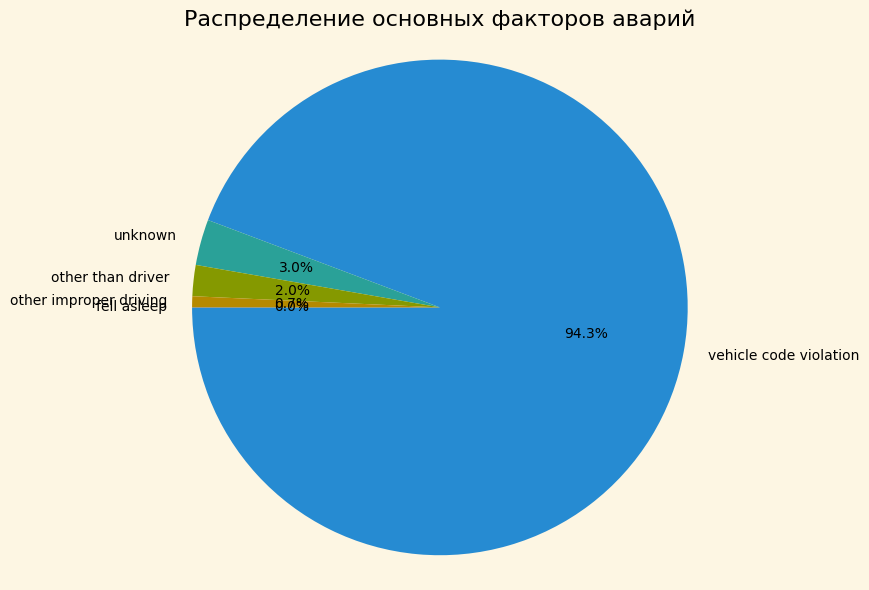

In [ ]:
collision_factors = df_cause.groupby('Основной фактор аварии')['Кол-во аварий по фактору'].sum().nlargest()
display(collision_factors)

plt.figure(figsize=(8, 6))
plt.pie(collision_factors.values, labels=collision_factors.index, autopct='%1.1f%%', startangle=180)
plt.title('Распределение основных факторов аварий')
plt.axis('equal')
plt.tight_layout()
plt.savefig('collision_factors.png')
plt.show()


<b>Выводы:</b>

В основном все аварии происходят с учасием машин в связи с нарушением ПДД

## Шаг 4. Создание модели для оценки водительского риска

### Подготовка набора данных
<a id='8-bullet'></a>

**Перечень факторов для обучения:**

- *county_location*, *intersection*, *distance* - локация, пересечение дорог и удалённость от трассы потенциально могут влиять на вероятность проишесвтия

- *weather_1*, *lighting* - Погодные условия и освещенность

- *location_type*, *road_surface*, *road_condition_1* - состояния дороги явлются важными факторами


- *collision_time* и *collision_date* - Время и дата аварии


- *vehicle_type*, *vehicle_transmission* и *vehicle_age* - тип кузова, КПП и возраст авто


- *party_sobriety*, *party_drug_physical*, *cellphone_in_use* - состояние водителя


at_fault - Виновник (таргет)

In [ ]:
df = pd.read_sql_query('''

SELECT
    p.at_fault,
    p.party_sobriety,
    p.party_drug_physical,
    p.cellphone_in_use,
    v.vehicle_age,
    v.vehicle_transmission,
    v.vehicle_type,
    EXTRACT(HOUR FROM c.collision_time) AS collision_hour,
    EXTRACT(MONTH FROM c.collision_date) AS collision_month,
    EXTRACT(DAY FROM c.collision_date) AS collision_day,
    c.road_condition_1,
    c.road_surface,
    c.location_type,
    c.lighting,
    c.weather_1,
    c.distance,
    c.intersection,
    c.county_location
FROM
    parties p
JOIN
    vehicles v ON p.case_id = v.case_id AND p.party_number = v.party_number
JOIN
    collisions c ON c.case_id = p.case_id
WHERE
    p.party_type = 'car'
    AND c.collision_damage != 'scratch'
    AND EXTRACT(YEAR FROM c.collision_date) = 2012

''', engine)


In [ ]:
display(df.info())

df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   at_fault              56248 non-null  int64  
 1   party_sobriety        55376 non-null  object 
 2   party_drug_physical   2857 non-null   object 
 3   cellphone_in_use      51777 non-null  float64
 4   vehicle_age           54554 non-null  float64
 5   vehicle_transmission  55389 non-null  object 
 6   vehicle_type          56248 non-null  object 
 7   collision_hour        56160 non-null  float64
 8   collision_month       56248 non-null  float64
 9   collision_day         56248 non-null  float64
 10  road_condition_1      55999 non-null  object 
 11  road_surface          55900 non-null  object 
 12  location_type         25932 non-null  object 
 13  lighting              56094 non-null  object 
 14  weather_1             56080 non-null  object 
 15  distance           

None

,at_fault,party_sobriety,party_drug_physical,cellphone_in_use,vehicle_age,vehicle_transmission,vehicle_type,collision_hour,collision_month,collision_day,road_condition_1,road_surface,location_type,lighting,weather_1,distance,intersection,county_location
0,0,had not been drinking,None,0.0,10.0,manual,sedan,2.0,1.0,15.0,normal,dry,None,dark with street lights,clear,21.0,0.0,contra costa
1,0,impairment unknown,G,0.0,NaN,auto,sedan,12.0,4.0,19.0,normal,dry,highway,daylight,clear,150.0,0.0,ventura


### Исследовательский анализ и изменение данных
<a id='9-bullet'></a>

In [ ]:
#Функция для отбора категорий в списки
def select_type_list(df, column_type):
    return df.select_dtypes(include=column_type).columns.tolist()

df['at_fault'] = df['at_fault'].astype('category')
df['cellphone_in_use'] = df['cellphone_in_use'].astype('category')
df['intersection'] = df['intersection'].astype('category')

int_col = cat = select_type_list(df, ['int', 'float64'])
cat = select_type_list(df, ['object', 'category'])

In [ ]:
#Функция по поиску дублей
def analyze_df(df, categorical_traits):

    print('Количество пропусков в солбцах:')
    display(df.isna().mean() * 100)

    print('Количество дубликатов в столбцах:')
    display(df.apply(lambda col: col.duplicated().sum()))

    print('Количество дубликатов в строках:')
    display(df.duplicated().sum())

    for trait in categorical_traits:
        print(f"Уникальные значения для {trait}: {df[trait].unique()}")


display(analyze_df(df, cat))

Количество пропусков в солбцах:


,0
at_fault,0.000000
party_sobriety,1.550277
party_drug_physical,94.920708
cellphone_in_use,7.948727
vehicle_age,3.011663
vehicle_transmission,1.527165
vehicle_type,0.000000
collision_hour,0.156450
collision_month,0.000000
collision_day,0.000000


Количество дубликатов в столбцах:


,0
at_fault,56246
party_sobriety,56241
party_drug_physical,56242
cellphone_in_use,56245
vehicle_age,56227
vehicle_transmission,56245
vehicle_type,56245
collision_hour,56223
collision_month,56236
collision_day,56217


Количество дубликатов в строках:


170

Уникальные значения для at_fault: [0, 1]
Categories (2, int64): [0, 1]
Уникальные значения для party_sobriety: ['had not been drinking' 'impairment unknown'
 'had been drinking, under influence'
 'had been drinking, impairment unknown'
 'had been drinking, not under influence' None 'not applicable']
Уникальные значения для party_drug_physical: [None 'G' 'under drug influence' 'sleepy/fatigued' 'not applicable'
 'impairment - physical']
Уникальные значения для cellphone_in_use: [0.0, NaN, 1.0]
Categories (2, float64): [0.0, 1.0]
Уникальные значения для vehicle_transmission: ['manual' 'auto' None]
Уникальные значения для vehicle_type: ['sedan' 'coupe' 'other']
Уникальные значения для road_condition_1: ['normal' None 'construction' 'reduced width' 'obstruction' 'holes'
 'other' 'flooded' 'loose material']
Уникальные значения для road_surface: ['dry' 'wet' 'snowy' None 'slippery']
Уникальные значения для location_type: [None 'highway' 'ramp' 'intersection']
Уникальные значения для lighting

None

In [ ]:
#Заполнение пропусков в кат. столбцах "неизвестным" значением
df = df.apply(lambda x: x.fillna('Unknown') if x.dtype in ['object'] else x)

#Удаление пропусоков в столбцах категорий
df = df.dropna(subset=df.select_dtypes(include=['category']).columns)

display(len(df))
#Удаление дублей
df = df.drop_duplicates()

#Проверка
display(df.duplicated().value_counts())
display(len(df))

51653

,count
False,51499


51499

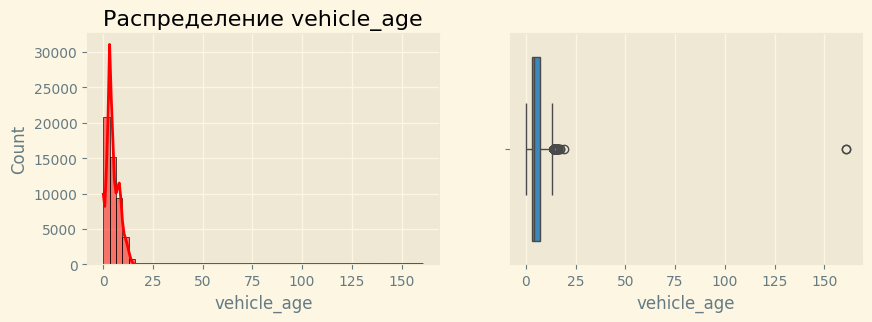

,vehicle_age
count,50113.000000
mean,4.863129
std,3.253474
min,0.000000
25%,3.000000
50%,4.000000
75%,7.000000
max,161.000000


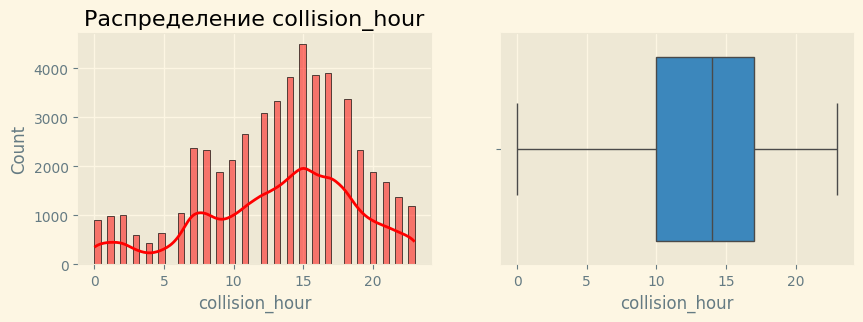

,collision_hour
count,51418.000000
mean,13.316426
std,5.453625
min,0.000000
25%,10.000000
50%,14.000000
75%,17.000000
max,23.000000


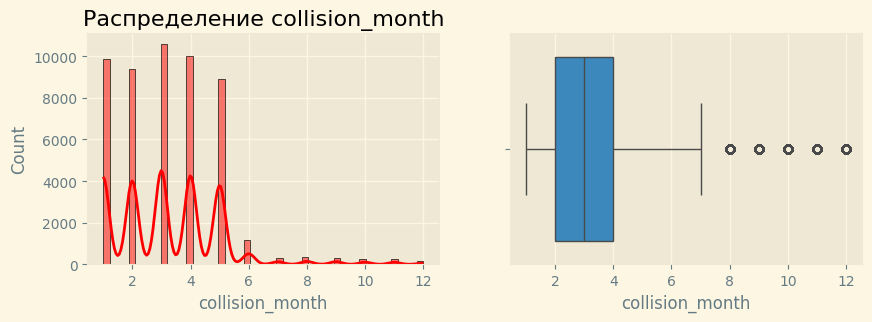

,collision_month
count,51499.000000
mean,3.234665
std,1.800634
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,12.000000


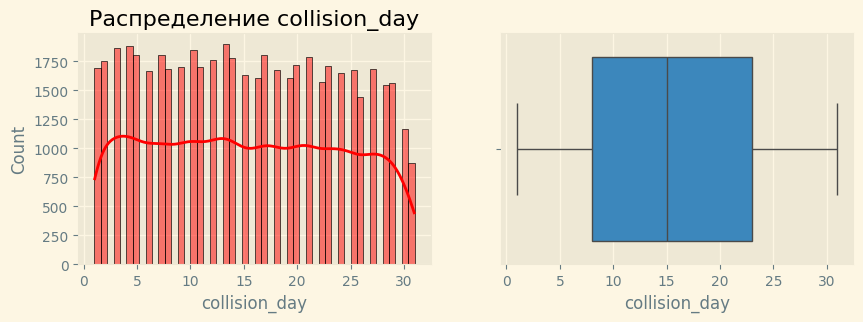

,collision_day
count,51499.000000
mean,15.308705
std,8.708656
min,1.000000
25%,8.000000
50%,15.000000
75%,23.000000
max,31.000000


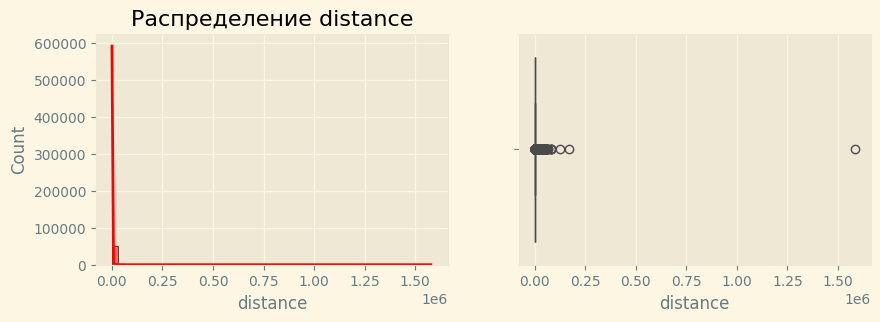

,distance
count,5.149900e+04
mean,9.167469e+02
std,7.558878e+03
min,0.000000e+00
25%,1.300000e+01
50%,1.500000e+02
75%,6.195000e+02
max,1.584000e+06


In [ ]:
for sign in int_col:
    plt.figure(figsize=(10,  3))

    #Гистограмма
    plt.subplot(1,  2,  1)
    sns.histplot(df[sign], kde=True, color='red', edgecolor='black', bins=50)
    plt.title(f'Распределение {sign}')

    #Построение ящика
    plt.subplot(1,  2,  2)
    sns.boxplot(df[sign], orient="h")
    plt.setp(plt.gca(),  'yticklabels', [])

    plt.show()
    display(df[sign].describe())

**Вывод**

Присутствуют явные выбросы в ворасте авто и расстоянии от трассы, устраню их  

Во времени аварии всё еще присутствуют пропуски, заполню их, т.к данные без выбросов и почти с нормальным распределением, заполню их средним значением

In [ ]:
df['collision_hour'] = df['collision_hour'].fillna(df['collision_hour'].mean())

df = df.loc[df['vehicle_age'] <= 30]
df = df.loc[df['distance'] < 2000]

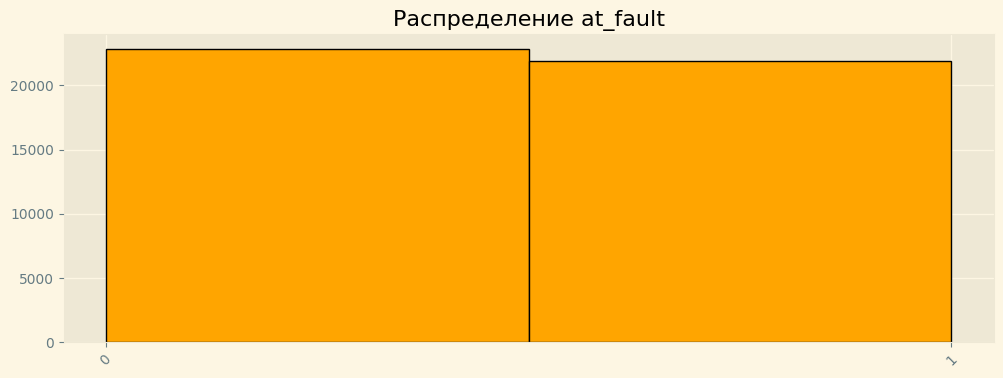

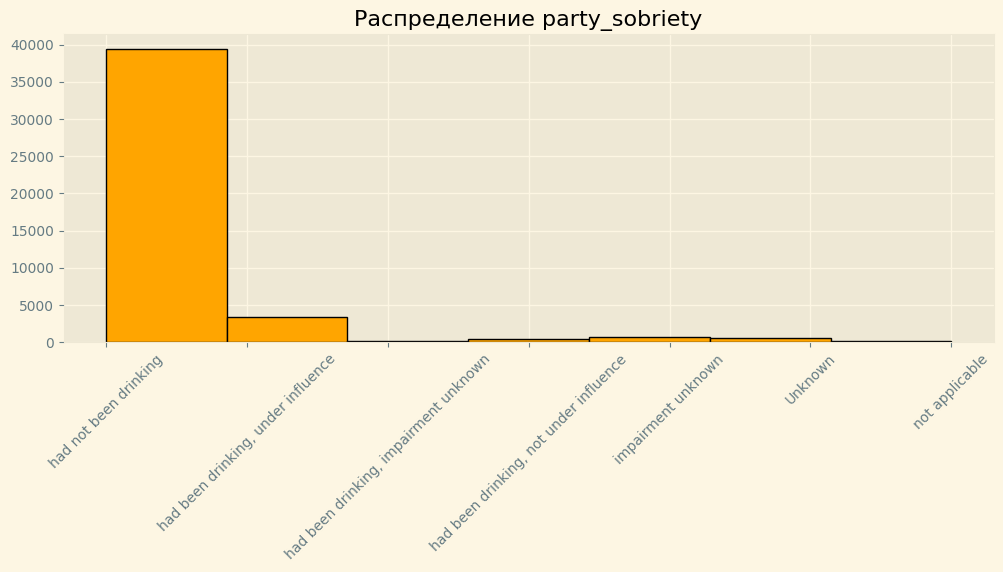

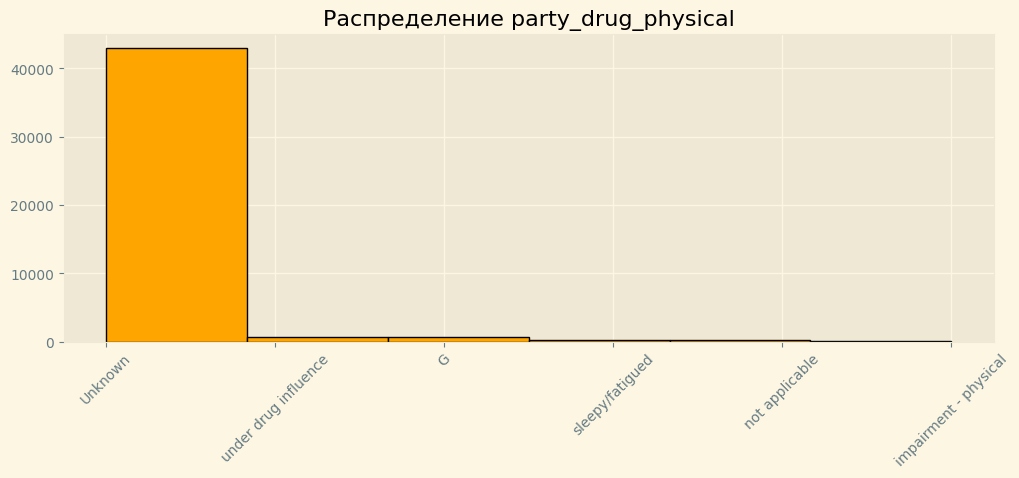

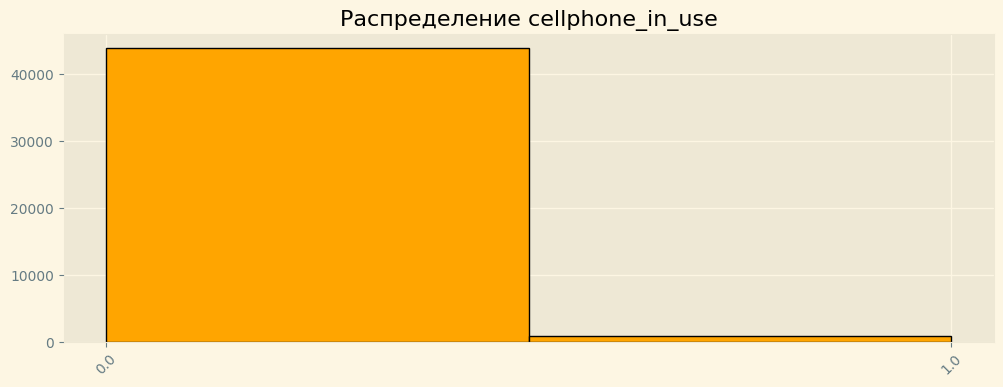

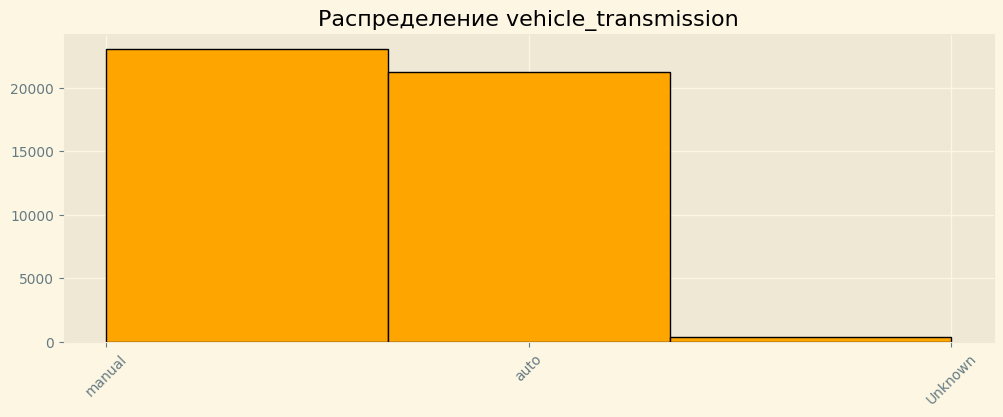

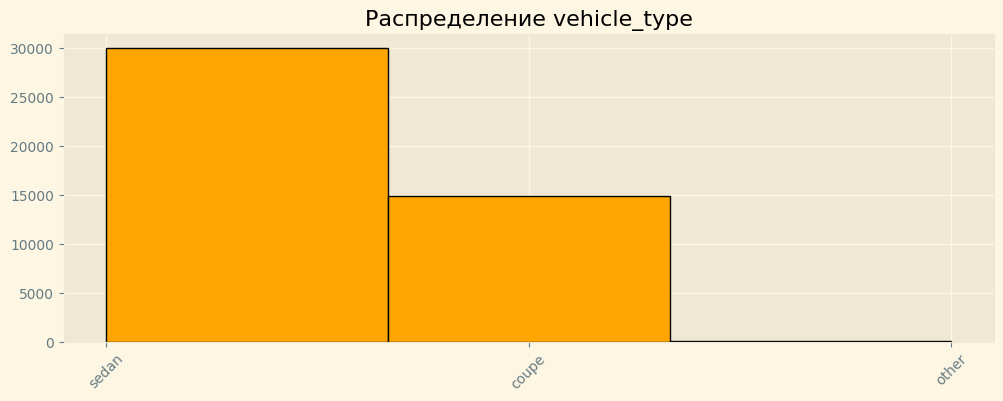

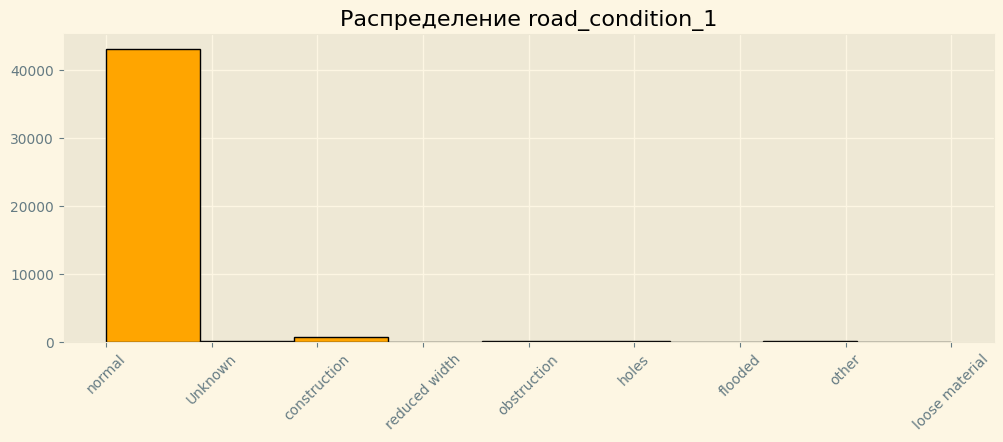

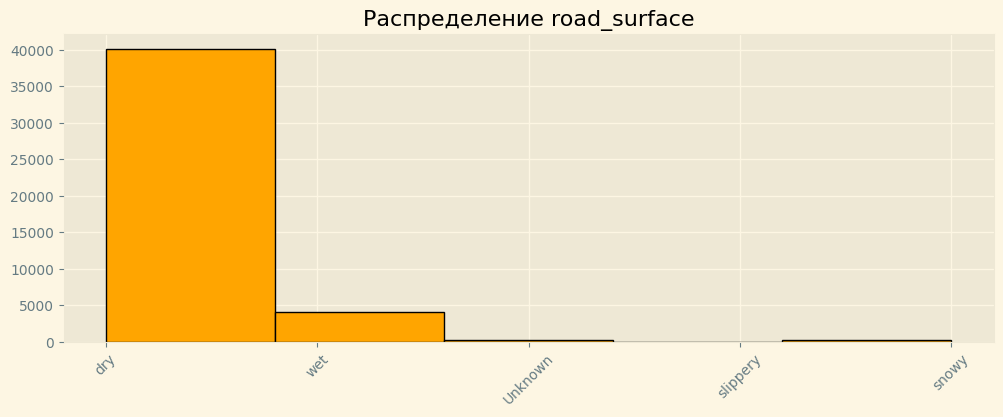

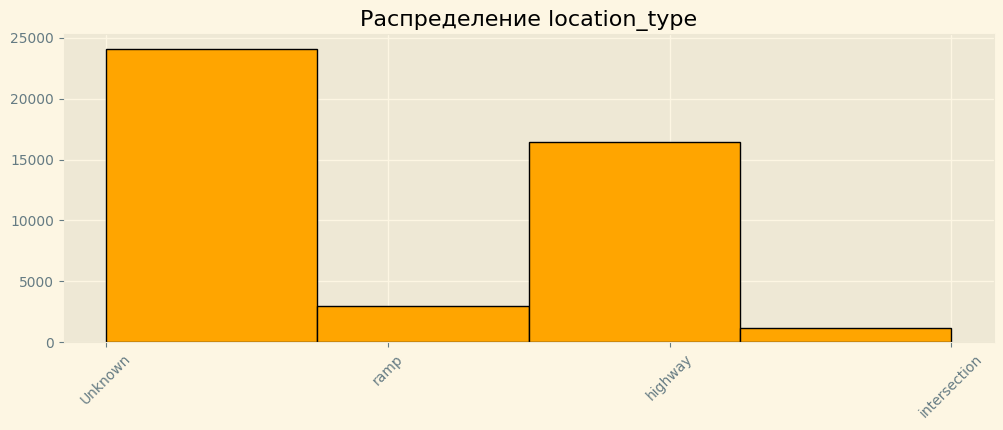

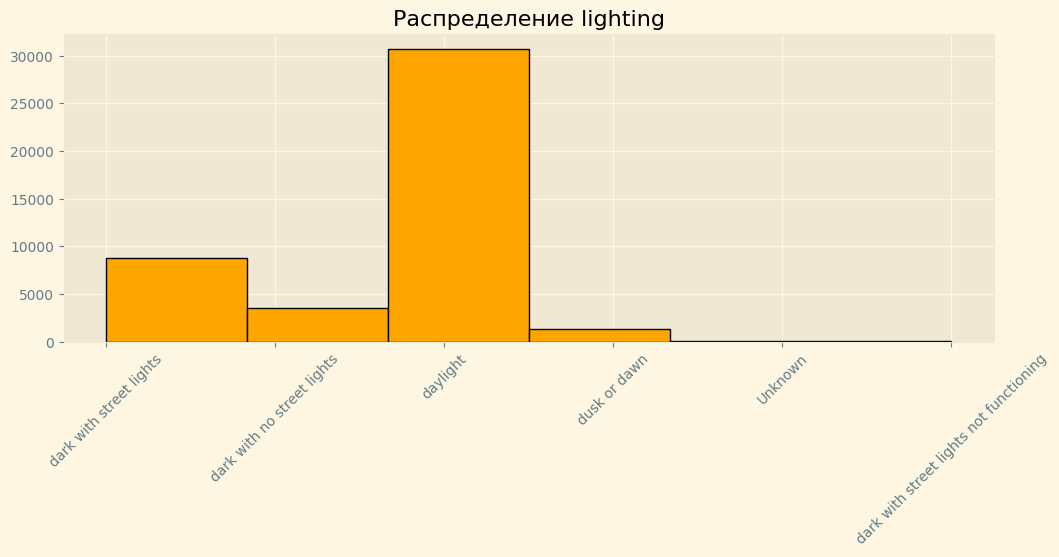

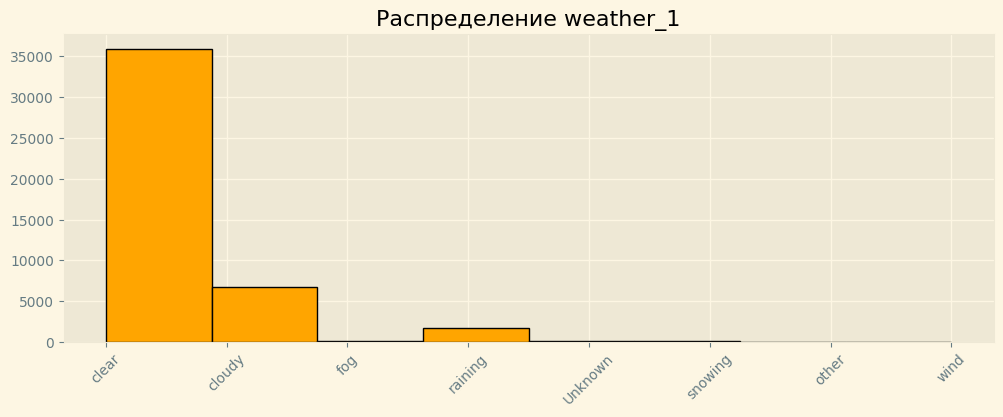

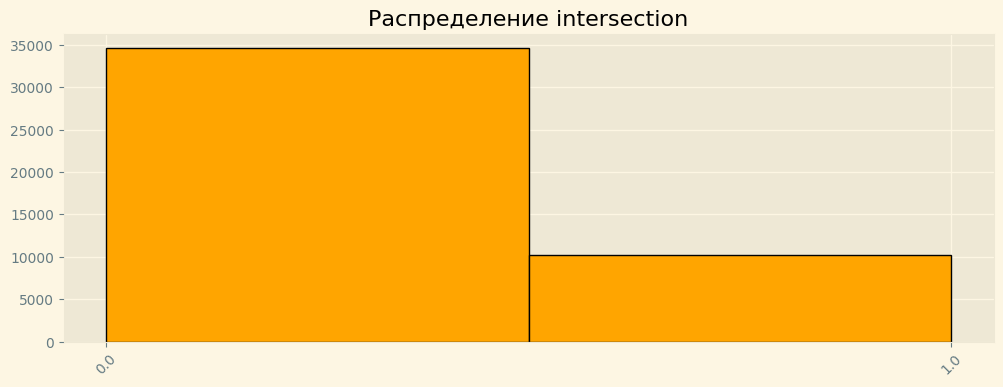

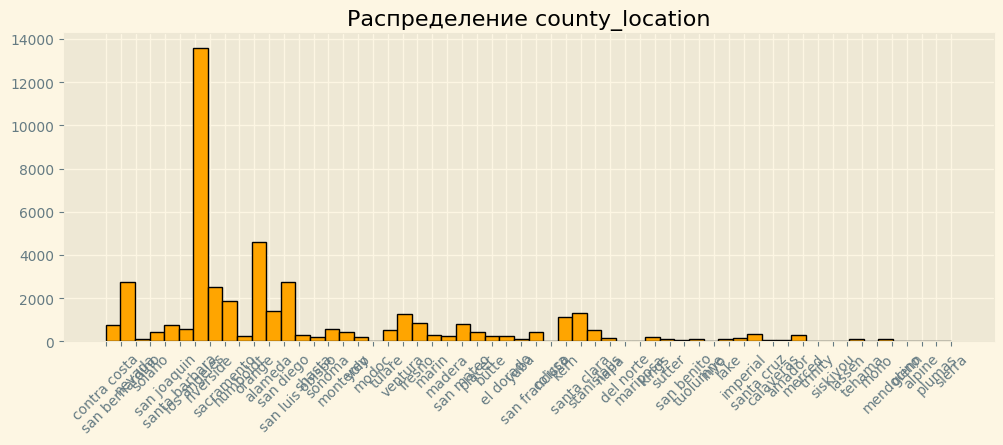

In [ ]:
#Функция для визуализации категориальных значений
for sign in cat:
    unique_values = df[sign].unique()
    num_bins = len(unique_values)

    plt.figure(figsize=(12,  4))
    plt.hist(df[sign], bins=num_bins, align='mid', edgecolor='black', color='orange')
    plt.xticks(range(num_bins), unique_values, rotation=45)
    plt.title(f'Распределение {sign}')
    plt.show()

**Вывод**

Распределение в категориальных столбцах зачастую неравномерное, на моменте обучения возможно стоит ровнять сэмплированием

### Подготовка выборок для обучения
<a id='10-bullet'></a>

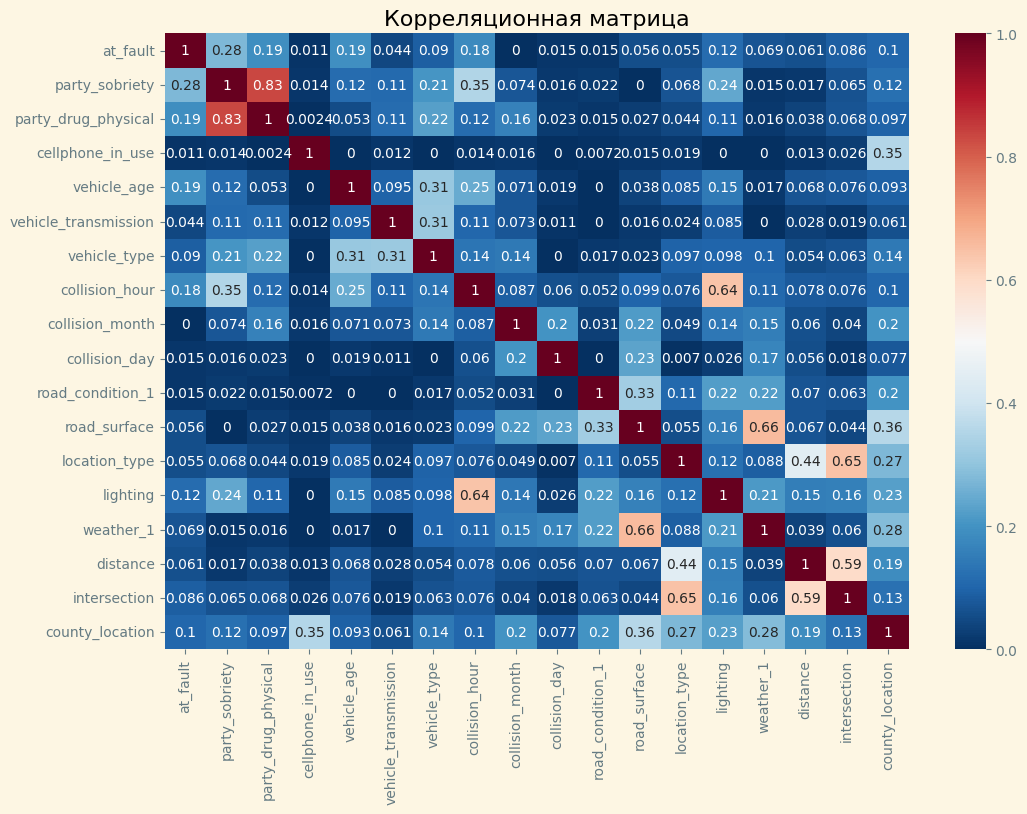

In [ ]:
#Построение кор. матрицы
plt.figure(figsize=(12, 8));
sns.heatmap(df.sample(25000).phik_matrix(interval_cols=['vehicle_age', 'distance',
                                                        'collision_hour', 'collision_month',
                                                        'collision_day']),
            annot=True, cmap='RdBu_r');
plt.title('Корреляционная матрица');
plt.show();

**Вывод**

- С виновностью в аварии коррелирует относительно немного признаков, в основном это:
-- Трезвость
-- Психологическое состояние
-- Возраст авто
-- Освещение
-- Время дня

- Признаки с низкой корреляцией удалю (Дистанция от главной дороги, день аварии, использование телефона и пара дорожных состояний)

In [ ]:
#Список для удаления
incoming_signs = ['cellphone_in_use', 'collision_day', 'distance', 'location_type',
                  'road_condition_1', 'intersection', 'road_surface', 'collision_month',
                  'weather_1', 'vehicle_type']

df = df.drop(incoming_signs, axis=1)

#Обновление колич. и категориальных признаков
int_col = select_type_list(df, ['int', 'float'])
cat = select_type_list(df, ['object', 'category'])

cat.remove('at_fault')

In [ ]:
#Функция для отбора уникальных значений и последующего кодирования
def uni_val(df, columns):
    result = {}
    for column in columns:
        if column in df.columns:
            df[column] = df[column]#.fillna('Unknown')
            result[f'unique_{column}'] = df[column].unique().tolist()
    return result

ca_di = uni_val(df, cat)

categories = []
for category_name, category_values in ca_di.items():
    categories.append(category_values)

In [ ]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

#Разбивка данных
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['at_fault'], axis=1),
    df['at_fault'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE)


#Пайплайны предобрадотки
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OrdinalEncoder(categories=categories,
                               handle_unknown='use_encoded_value', unknown_value=-1))
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, int_col),
        ('cat', categorical_transformer, cat)
    ]
)

**Метрика для оценки моделей**

Выбрана метрика `ROC-AUC` со стратегией решения `OVO` из-за большого количества категориальных данных и их несбалансированности

Плюс нет привязки к ложно отрицательным или истонно положительным предсказаниям, поэтому соотношение между ними, которое оценивает `ROC-AUC` подходит лучше всего


## Шаг 5. Поиск лучшей модели

### Функция для обучения
<a id='11-bullet'></a>

In [ ]:
def train_model(model_class, param_grid, X_train, y_train, sample_size=None):

    #Пайплайн для предобработки под каждую модель
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model_class())
    ])

    #Из-за большого кол-ва данных ввёл возможность выбора размера выборки для ускорения обучения
    if sample_size is not None:
        rng = check_random_state(None)

        #Далее небольшие кульбиты с индексацией из-за случайности данных в выборках
        unique_indices = np.unique(X_train.index)

        selected_indices = rng.choice(unique_indices, size=min(sample_size, len(unique_indices)), replace=False)

        X_sample, y_sample = X_train.loc[selected_indices], y_train.loc[selected_indices]
    else:
        X_sample, y_sample = X_train, y_train

    #ПРоверка на совпадение индексов
    common_indices = set(X_sample.index) & set(y_sample.index)

    common_indices_list = list(common_indices)

    X_sample, y_sample = X_sample.loc[common_indices_list], y_train.loc[common_indices_list]

    #Случайный подбор
    randomized_search = RandomizedSearchCV(
        pipe,
        param_grid,
        cv=6,
        scoring='roc_auc_ovo',
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=0
    )

    #Обучение
    randomized_search.fit(X_sample, y_sample)

    res = randomized_search.cv_results_

    best_model = randomized_search.best_estimator_.steps[-1][1]

    return res, best_model


### Гиперпараметры моделей
<a id='12-bullet'></a>

In [ ]:
#Словари
param_grid_catboost = {
    'model__iterations': range(100, 501, 100),
    'model__learning_rate': [0.001, 0.005, 0.01],
    'model__depth': range(3, 13, 2),
    'model__l2_leaf_reg': [3, 5, 7],
    'model__random_strength': [0.5, 1, 2],
    'model__verbose': [False]
}

param_grid_knn = {
    'model__n_neighbors': range(5, 51, 5),
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'model__metric': ['euclidean', 'manhattan', 'minkowski']
}

param_grid_randomforest = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [8, 12, 16],
    'model__min_samples_split': [5, 10, 15],
    'model__min_samples_leaf': [2, 4, 6],
    'model__class_weight': ['balanced', 'balanced_subsample']
}


In [ ]:
models = [
    ('KNN', KNeighborsClassifier),
    ('RandomForest', RandomForestClassifier),
    ('CatBoost', CatBoostClassifier)
]

results = {}
best_models = {}

#Цикл обучения и установка необходимого кол-ва данных
sample_sizes = [None]

for sample_size in sample_sizes:
    for model_name, model_class in models:
            model_results, best_model = train_model(
                model_class,
                eval(f'param_grid_{model_name.lower()}'),
                X_train, y_train,
                sample_size=sample_size
            )

            results[f'{model_name}_{sample_size}'] = model_results
            best_models[f'{model_name}_{sample_size}'] = best_model

### Результат обучения
<a id='13-bullet'></a>

In [ ]:
#Функция для извлечения из словаря результатов нужных данных
def get_best_hyperparameters_and_roc_auc(results):
    best_params = {}
    best_roc_auc = {}

    for model_name, scores in results.items():
        #Поиск лучших параметров
        best_idx = np.argmax(scores['mean_test_score'])
        best_params[model_name] = scores['params'][best_idx]
        best_roc_auc[model_name] = scores['mean_test_score'][best_idx]

    return best_params, best_roc_auc

best_params, best_roc_auc = get_best_hyperparameters_and_roc_auc(results)

#Результат
print("\nЛучшие гиперпараметры и ROC-AUC для каждой модели:")
for model, params in best_params.items():
    print(f"\n{model}:")
    print(f"ROC-AUC: {best_roc_auc[model]:.4f}")
    print("Гиперпараметры:")
    for key, value in params.items():
        print(f"  {key}: {value}")

print("\nСравнение лучшего ROC-AUC:")
for model, roc_auc in sorted(best_roc_auc.items(), key=lambda x: x[1], reverse=True):
    print(f"{model}: {roc_auc:.4f}")


Лучшие гиперпараметры и ROC-AUC для каждой модели:

KNN_None:
ROC-AUC: 0.6384
Гиперпараметры:
  model__weights: uniform
  model__n_neighbors: 50
  model__metric: euclidean
  model__algorithm: kd_tree

RandomForest_None:
ROC-AUC: 0.6721
Гиперпараметры:
  model__n_estimators: 200
  model__min_samples_split: 5
  model__min_samples_leaf: 6
  model__max_depth: 8
  model__class_weight: balanced_subsample

CatBoost_None:
ROC-AUC: 0.6718
Гиперпараметры:
  model__verbose: False
  model__random_strength: 2
  model__learning_rate: 0.01
  model__l2_leaf_reg: 7
  model__iterations: 400
  model__depth: 7

Сравнение лучшего ROC-AUC:
RandomForest_None: 0.6721
CatBoost_None: 0.6718
KNN_None: 0.6384


**Вывод**

По результам тестирования на тренировочной выборке, лучшей моделью становится RandomForest с полным набором строк для обучения

## Шаг 6. Проверка лучшей модели

In [ ]:
#Предобработка тестовых данных
X_test_transformed = preprocessor.fit(X_test).transform(X_test)

y_pred = best_models['RandomForest_None'].predict(X_test_transformed)

print("ROC-AUC на тесте:", roc_auc_score(y_test, best_model.predict_proba(X_test_transformed)[:, 1]).round(4))

ROC-AUC на тесте: 0.6745


### Оценка качества определения классов
<a id='14-bullet'></a>

In [ ]:
test_class_accuracies = []
test_class_precision = []
test_class_roc_auc = []

test_labels = np.unique(y_test)
for label in test_labels:
    true_labels = y_test == label
    pred_labels = y_pred == label

    pred_probs = best_models['RandomForest_None'].predict_proba(X_test_transformed)[:, 1]

    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, average='weighted',
                                zero_division=0)
    roc_auc = roc_auc_score(true_labels, pred_probs)

    test_class_accuracies.append(accuracy)
    test_class_precision.append(precision)
    test_class_roc_auc.append(roc_auc)


data = {
    'class': test_labels,
    'accuracy': test_class_accuracies,
    'precision': test_class_precision,
    'roc_auc': test_class_roc_auc
}

df_results = pd.DataFrame(data)
display(df_results)

,class,accuracy,precision,roc_auc
0,0,0.628173,0.640159,0.325812
1,1,0.628173,0.640159,0.674188


**Вывод**

Небольшая точность и аномально низкий ROC-AUC указывают на плохое распознование класса невиновности

Класс виновности в аварии тоже чуть лучше случайности выбора присваивается, но имеет уже лучшую по сравнению с невиновностью распознаваемость моделью

### Матрица ошибок
<a id='15-bullet'></a>

,y_pred,y_true
0,7576,5744
1,3612,5444


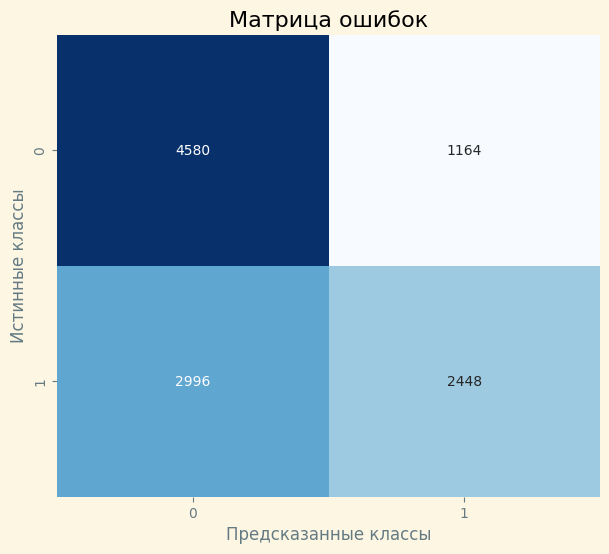

In [ ]:
cm = confusion_matrix(y_test, y_pred)

y_pred_series = pd.Series(y_pred.flatten())

cm_df = pd.concat([y_pred_series.value_counts(), y_test.value_counts()],
                  axis=1, keys=['y_pred', 'y_true'])

display(cm_df)

plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Предсказанные классы')
plt.ylabel('Истинные классы')
plt.title('Матрица ошибок')
plt.show()

**Вывод**

Модель путает виновных учатников с невиновными, отадвая предпочтение 0 классу вместо 1


Можно попробовать установить порог класса для решения проблемы  

### Анализ важности признака
<a id='16-bullet'></a>

In [ ]:
feature_names = X_test.columns.tolist()

#Функция для извлечения важности признаков
def analyze_feature_importance(model, X_test, y_test):
    feature_importances = best_models['RandomForest_None'].feature_importances_

    #Сортировка
    sorted_features = sorted(zip(feature_importances, feature_names),
                              key=lambda x: abs(x[0]), reverse=True)

    print("Важные признаки для решений модели:")
    for importance, feature in sorted_features:
        print(f"{feature}: {importance:.4f}")

#Результат
analyze_feature_importance(best_model, X_test_transformed, y_test)

Важные признаки для решений модели:
vehicle_age: 0.5622
party_sobriety: 0.1360
party_drug_physical: 0.0957
vehicle_transmission: 0.0948
county_location: 0.0521
collision_hour: 0.0349
lighting: 0.0244


**Вывод**

- Возраст транспортных средств является наиболее значимым фактором, влияющим на виновность участника ДТП (половина от важности решений).

- Степень алкогольного опьянения также играет важную роль в определении виновности участника.

- Факторы, связанные с условиями окружающей среды (освещение, покрытие дорог), время происшествия,  и состояние участников (физическое состояние, употребление наркотиков), также оказали влияние.


Старые автомобили могут быть более склонны к поломкам или иметь нарушение систем безопасности, что увеличивает риск нарушения управлемости в критичный момент.

Состояние участников (опьянение или прием наркотиков) значительно повышает риск виновности в аварии.

**Предложения**

Адаптивная система помощи водителю:
Алгоритм, следяший за возрастоми/состоянием автомобиля, и при помощи интерфейса призывающий водителя к отказу продолжать прокат данного авто или заехать в сервисный центр для ремонта/обслуживания или замене компонентов, а в критических случаях/состояниях не допускать к упарвлению авто

## Общий вывод

В проекте реализовал:

- Загрузку таблиц с использованием sql запросов

- Исследование таблиц и корректировки значений

- Анализ факторов ДТП

- Создана модель для оценки водительского риска



Лучшей моделью по метрике ROC_AUC стал "Случайный лес", гиперпараметры для которого были подобраны чрез случайный поиск

Модель не совсем точно предсказывает виновность в аварии

Система адекватной оценки риска вполне возможна, особенно для наиболее частых мелких проишествий

Для улучшения оценки риска необходимо собирать больше данных о тяжёлых и фатальных причинах и аварийных случаях (состояния участников/авто/и прочего при данных авариях), при изучении БД явно видно мизерное кол-во данных случаев, но для каршеринговой компании они потенциально будут наиболее тяжёлыми, нежели царапины или легкие повреждения

Необходим сбор:

- Данных о скорости движения авто (на основе анализа аварий можно определить оптимальную максимальную скорость для безопасного проката)

- Продолжительности нахождения за рулем

- Локации припаркованного авто до аварии (парковка повзле клуба/ретсорана и тд)

- Водительский стаж и нарушения ПДД
